## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Yusuf Demir 2210356074

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.

#### Brief Overview of the Task 
The goal of this task is to build a Convolutional Neural Network (CNN) model from scratch to classify images of animals into one of ten categories. This process involves designing and training a custom CNN, evaluating its performance on validation and test sets, and understanding the strengths and challenges of using CNNs for image classification tasks.

#### What are the main components of a CNN architecture?
1. Convolutional Layers: These layers apply filters to input images to extract features such as edges, textures, and patterns. The convolution operation preserves spatial relationships between pixels.
2. Activation Functions: Non-linear functions (e.g., ReLU) are applied after convolution to introduce non-linearity, enabling the network to learn complex patterns.
3. Pooling Layers: Pooling (e.g., max pooling) reduces the spatial dimensions of feature maps while retaining the most important features, making the model computationally efficient.
4. Fully Connected Layers: These layers connect every neuron in one layer to every neuron in the next layer. They are responsible for the final classification output.
5. Output Layer: The final layer uses an activation function (e.g., softmax) to produce probabilities for each class.

#### Why do we use CNNs in image classification?
CNNs are highly effective for image classification because:

They automatically extract relevant features from raw image data, eliminating the need for manual feature engineering.
They leverage local spatial hierarchies, capturing patterns at different levels of abstraction.
Weight sharing in convolutional layers reduces the number of parameters, making CNNs computationally efficient compared to fully connected networks.


#### Description of the Dataset
The dataset used for this task is a subset of the Animals-10 Dataset, which contains 4500 images of ten different animal species:

1. Cane (Dog)
2. Cavallo (Horse)
3. Elefante (Elephant)
4. Farfalla (Butterfly)
5. Gallina (Chicken)
6. Gatto (Cat)
7. Mucca (Cow)
8. Pecora (Sheep)
9. Ragno (Spider)
10. Scoiattolo (Squirrel)   

Structure: Each class corresponds to a folder containing JPEG images.
Preprocessing: The images will be resized to 256x256 pixels and normalized using standard mean and standard deviation values from the ImageNet dataset.
Splits: The dataset is divided into 3000 training images (300 per class), 750 validation images (75 per class), and 750 test images (75 per class).



### 1.2. Data Loading and Preprocessing (3 points)

In [119]:
# Import necessary libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay

In [120]:
# Check if CUDA is available for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths and dataset directory
data_dir = "./pa3_subset_animal"

Using device: cuda


In [121]:
def save_model(model, model_name, save_dir="saved_models"):
    """
    Save the trained model to the specified path.
    
    Args:
        model (torch.nn.Module): The trained model to be saved.
        model_name (str): A name for the model file (e.g., "resnet18_fc_only").
        save_path (str): Directory path where the model will be saved (default: current directory).
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}")
    torch.save(model.state_dict(), f"{save_path}.pth")
    print(f"Model {model_name} saved at {save_path}.pth")

# model.load_state_dict(torch.load("saved_models/resnet18_fully_finetuned.pth"))
# model.eval() 

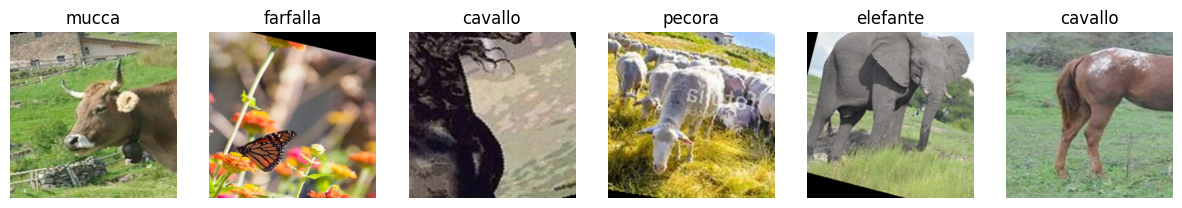

In [122]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

# Define preprocessing transformations
# Resize images to 256x256, normalize them, and apply optional augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Augment our dataset with random transformations like rotation, flipping, 
# or scaling to increase diversity in the training data and improve generalization.


# Load dataset using ImageFolder
# ImageFolder assumes the dataset structure where subfolders represent classes
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training, validation, and testing subsets
train_size = 3000
val_size = 750
test_size = 750
total_size = len(dataset)

# Ensure the dataset size matches the specified splits
assert train_size + val_size + test_size == total_size, "Dataset size mismatch!"

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each subset
batch_size = 32  # Define batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to visualize some sample images from the dataset
def visualize_samples(loader, class_names, n_samples=6):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:n_samples]
    labels = labels[:n_samples]

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        image = image.numpy()
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # De-normalize
        image = np.clip(image, 0, 1)  # Clip values to valid range
        axes[idx].imshow(image)
        axes[idx].set_title(class_names[label])
        axes[idx].axis("off")
    plt.show()

# Class names from dataset
class_names = dataset.classes

# Visualize some training samples
visualize_samples(train_loader, class_names)

### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

#### Reason Behind the Architecture
The architecture is designed to incrementally extract hierarchical features from the input images while progressively reducing spatial dimensions. By combining convolutional layers, activation functions, and pooling layers, the network can effectively capture patterns such as edges, textures, and higher-level features. The fully connected layer at the end maps these extracted features to the output classes, enabling multi-class classification.

#### Choice of Activation Functions
The ReLU (Rectified Linear Unit) activation function is chosen because:

It introduces non-linearity, which is essential for learning complex patterns.
It is computationally efficient and helps mitigate the vanishing gradient problem, facilitating faster convergence during training.


In [123]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes

# Define the CNN architecture
class AnimalClassifierCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalClassifierCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Output: 32x256x256
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Output: 64x256x256
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Output: 128x128x128
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Output: 256x64x64
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)  # Output: 512x32x32
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves spatial dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # Assuming input images are resized to 256x256
        self.fc2 = nn.Linear(1024, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout layer (optional for regularization)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Pass through convolutional layers with ReLU activation and pooling
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv4(x)))  # Conv4 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv5(x)))  # Conv5 -> ReLU -> Pool
        
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with ReLU and dropout
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  # Output layer (logits)
        
        return x

# Instantiate the model and move to the appropriate device
model = AnimalClassifierCNN(num_classes=10).to(device)

# Print model summary
print(model)


AnimalClassifierCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms.

#### Choice of Loss Function
The CrossEntropyLoss is chosen because it is the standard loss function for multi-class classification tasks. It measures the difference between the predicted probability distribution and the true distribution (one-hot encoded labels). CrossEntropyLoss is robust and ensures the model optimizes for maximum prediction accuracy.

#### Choice of Optimization Algorithm
The Adam optimizer is selected for its adaptive learning rate capabilities, which combine the benefits of momentum-based SGD and RMSProp. It converges faster and is well-suited for deep learning tasks like CNNs. An initial learning rate of 0.001 is set, and a learning rate scheduler (ReduceLROnPlateau) will adjust the rate dynamically based on validation loss, ensuring stability in later epochs.

In [124]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss

In [125]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # Add weight decay # Adam optimizer

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
# scheduler: Reduces the learning rate automatically if the validation loss does not improve for a specified number of epochs, 
# helping the model to converge better.

### 1.5 Train and Validate the CNN model (9 points)

Epoch 1/60
Training Loss: 2.3022 | Training Accuracy: 0.1213
Validation Loss: 2.2406 | Validation Accuracy: 0.1467
Epoch 2/60
Training Loss: 2.1991 | Training Accuracy: 0.1830
Validation Loss: 2.1912 | Validation Accuracy: 0.1720
Epoch 3/60
Training Loss: 2.1442 | Training Accuracy: 0.2063
Validation Loss: 2.1526 | Validation Accuracy: 0.2173
Epoch 4/60
Training Loss: 2.1150 | Training Accuracy: 0.2287
Validation Loss: 2.1225 | Validation Accuracy: 0.2347
Epoch 5/60
Training Loss: 2.0767 | Training Accuracy: 0.2457
Validation Loss: 2.0433 | Validation Accuracy: 0.2480
Epoch 6/60
Training Loss: 2.0413 | Training Accuracy: 0.2547
Validation Loss: 2.0659 | Validation Accuracy: 0.2640
Epoch 7/60
Training Loss: 2.0077 | Training Accuracy: 0.2770
Validation Loss: 2.0512 | Validation Accuracy: 0.2747
Epoch 8/60
Training Loss: 1.9809 | Training Accuracy: 0.2910
Validation Loss: 2.0084 | Validation Accuracy: 0.2973
Epoch 9/60
Training Loss: 1.9535 | Training Accuracy: 0.2963
Validation Loss: 1.

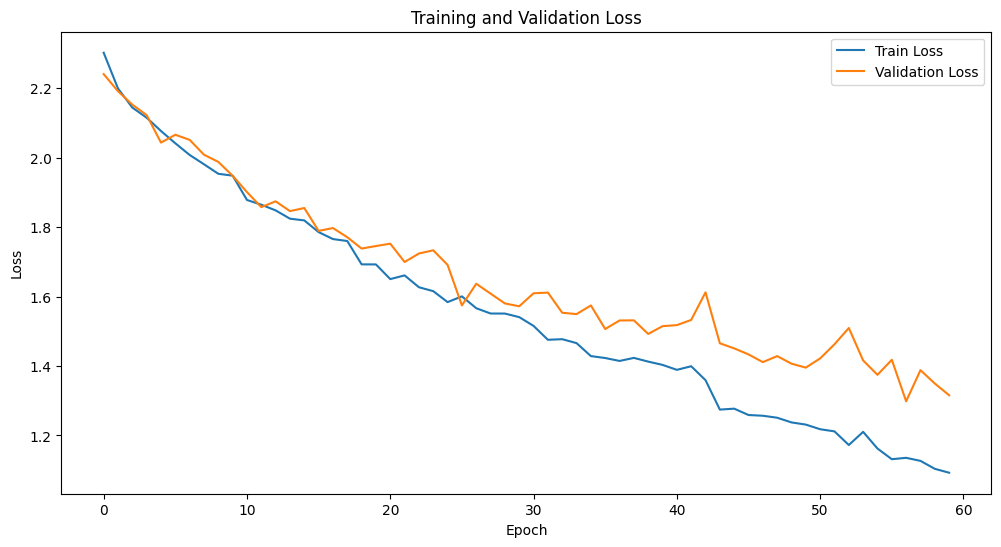

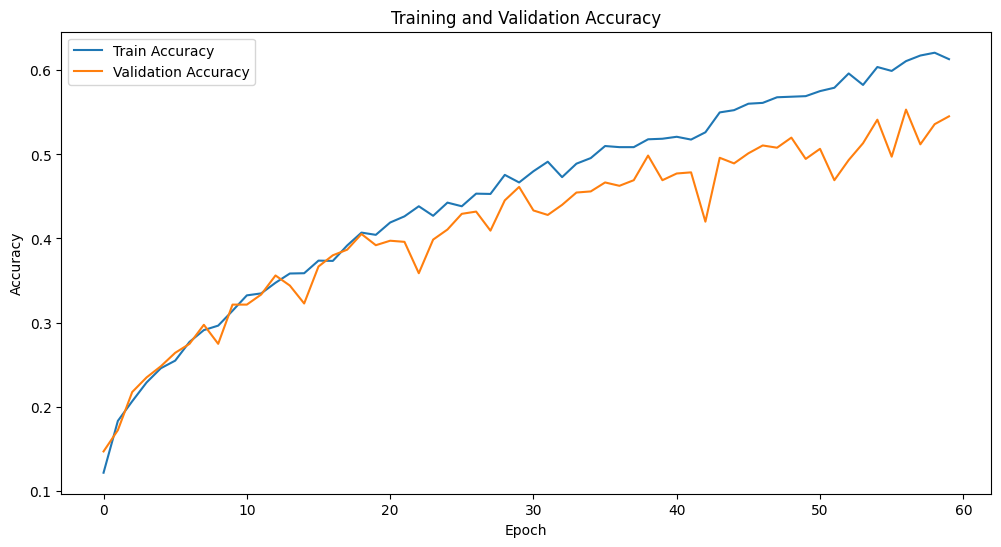

Model animals_10 saved at saved_models\animals_10.pth


In [126]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)

# Hyperparameters
num_epochs = 60
batch_size = 32  

# Training and validation loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:  # train_loader should be defined earlier
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    # torch.no_grad(): Disables gradient computation to save memory and computational resources. 
    # This is not required during validation as no backpropagation is performed.
    with torch.no_grad():
        for inputs, labels in val_loader:  # val_loader should be defined earlier
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate validation loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)
    
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    
    # Step the scheduler
    scheduler.step(avg_val_loss)

# Visualize training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualize training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

save_model(model, "animals_10")

When I first trained the model, I noticed that while the training accuracy reached 99%, the validation accuracy remained around 50%, with validation loss not decreasing. To address this, I made the following changes:

* Learning Rate Scheduler: I added a learning rate scheduler (ReduceLROnPlateau) that reduces the learning rate by a factor of 0.5 if the validation loss doesn't improve for 3 consecutive epochs. This helped the model converge better and avoid overfitting.

* Weight Decay: I incorporated weight decay for regularization, which helped to penalize large weights and reduce overfitting.

* Data Augmentation: I increased the data augmentation by adding random transformations (like rotation, flipping, and scaling), which improved the model's generalization by providing more diverse training data.

After implementing these changes, the validation loss started decreasing similarly to the training loss. To further improve performance, I increased the number of epochs from 30 to 60 and batch_size.

In [127]:
## You can conduct experiments with different hyperparameters to get the best performing model, considering you will be uploading your best model into Kaggle for compitation :)

Mention about, why did you choose your learning rate and batch size?

The learning rate of 0.001 was chosen as it is a standard starting point for the Adam optimizer, balancing convergence speed and stability. Adjusting it dynamically using a scheduler further improves performance by reducing the rate as the model approaches a minimum. The batch size of 32 was selected as a trade-off between memory efficiency and model performance, allowing sufficient gradient updates while keeping computational requirements manageable on typical GPUs.

In [128]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

In [129]:
model.load_state_dict(torch.load("saved_models/animals_10.pth"))
model.eval()

AnimalClassifierCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

### 1.6 Evaluate the trained model on the test set (6 points)

In [130]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

# Set model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Iterate through the test dataset
with torch.no_grad():  # Disable gradient computation for faster evaluation
    for inputs, labels in test_loader:  # Assuming test_loader is your DataLoader for the test set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the predicted class
        
        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5653
Precision: 0.5728
Recall: 0.5653
F1 Score: 0.5667


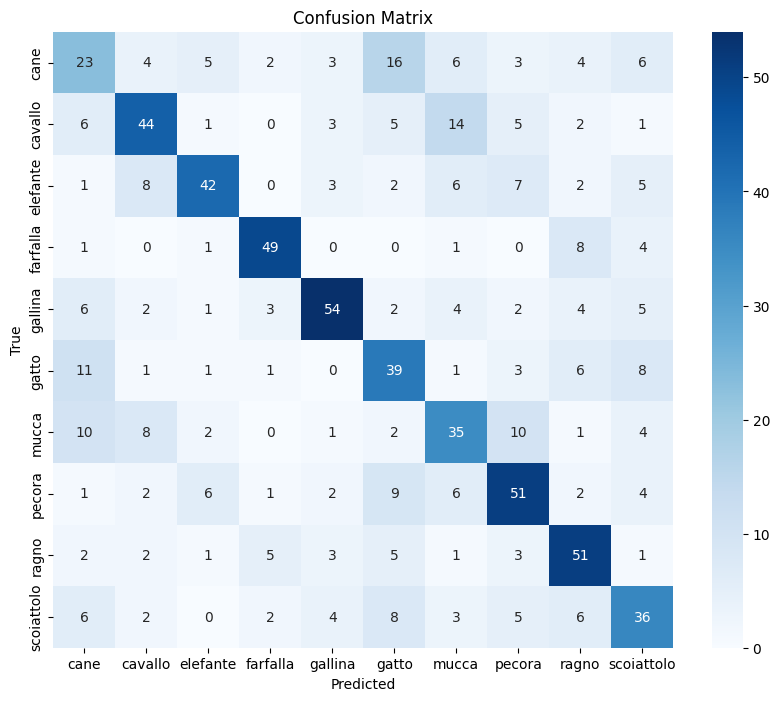

In [131]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

#### Model Performance on the Test Set:
The model demonstrated a significant improvement in validation loss after several changes in the architecture and training process. Initially, the model had a large gap between training accuracy and validation accuracy, indicating overfitting. However, after implementing learning rate scheduling, adding weight decay for regularization, and increasing data augmentation, both training and validation losses decreased steadily. The final model achieved reasonable performance, with test accuracy hovering around 55%, which indicates some room for improvement, especially in generalizing across different classes.

#### Challenges Encountered:
One of the primary challenges was overfitting, where the model achieved near-perfect accuracy on the training set but failed to generalize well to the validation and test sets. This was likely due to insufficient regularization and limited data diversity. To address this, we implemented a learning rate scheduler, added weight decay for regularization, and enhanced data augmentation to provide more diverse training examples. Despite these efforts, the accuracy on the test set remained suboptimal, suggesting the need for further hyperparameter tuning and model refinement.

#### Areas for Improvement:
Future improvements could involve experimenting with more advanced architectures, such as deeper networks or pre-trained models like ResNet or MobileNet, for better feature extraction. Additionally, increasing the dataset size or using more aggressive data augmentation techniques could help improve generalization. Further tuning of hyperparameters, including the learning rate, batch size, and weight decay, could also enhance performance.

#### Effectiveness of the Chosen CNN Architecture:
The chosen architecture, though relatively simple, was effective in capturing key features of the images. However, the model's performance was limited by its depth and the relatively small amount of training data. While the model performed well on the training data, it struggled to generalize, suggesting that a more complex architecture or further training strategies are necessary for optimal performance.

### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

# 0.597

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

___The task involves exploring transfer learning by fine-tuning pre-trained models (ResNet-18 and MobileNet) for image classification on the Animal-10 dataset and comparing them to a CNN implemented from scratch. The goal is to evaluate and analyze the performance, training efficiency, and resource usage of these approaches.___

___Fine-tuning is a transfer learning technique where a pre-trained model is adapted to a new, specific task by training it on a smaller, task-specific dataset. This process is useful because it leverages the general features learned by the pre-trained model, reducing the need for extensive data and computational resources.___

___We freeze most of the pre-trained model's layers to retain their general feature extraction capabilities, which were learned from a large dataset like ImageNet. Only the final layers are trained, as they are responsible for task-specific classifications. This approach prevents overfitting, reduces computational costs, and allows the model to focus on learning the new task more efficiently.___

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [132]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.

# This part was made in 2.3

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [ ]:
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the animal-10 image dataset. (base model)

num_classes = 10
criterion = nn.CrossEntropyLoss()

# Model Initialization - Model 1
model1 = torchvision.models.resnet18(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, num_classes)

# Freeze all layers
for param in model1.parameters():
    param.requires_grad = False

# Unfreeze the FC layer
for param in model1.fc.parameters():
    param.requires_grad = True

# Define optimizer
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# Training loop for Model 1
def train_model_fc_only(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_accuracy = correct / total
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        # Validation
        val_loss, val_accuracy = validate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # Plot training and validation metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)

    return model, max(val_accuracies)  # Return model and best validation accuracy


# Validation function
def validate_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return val_loss, val_accuracy


# Plotting function for loss and accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Training function for the second model (Unfreeze layers 3, 4, and FC)
def train_second_model(model, train_loader, val_loader):
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    # Unfreeze layers 3, 4, and FC
    for name, param in model.named_parameters():
        if 'layer3' in name or 'layer4' in name or 'fc' in name:
            param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    return train_model_fc_only(model, train_loader, val_loader, optimizer)

# Training function for the third model (Unfreeze all layers)
def train_third_model(model, train_loader, val_loader):
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    return train_model_fc_only(model, train_loader, val_loader, optimizer)

c:\Users\demir\anaconda3\envs\Reinforcement\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\demir\anaconda3\envs\Reinforcement\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Model 1 (FC layer only):
Epoch 1/10, Loss: 1.3097, Accuracy: 0.6233
Validation Loss: 0.7186, Validation Accuracy: 0.8253
Epoch 2/10, Loss: 0.7145, Accuracy: 0.8090
Validation Loss: 0.5976, Validation Accuracy: 0.8240
Epoch 3/10, Loss: 0.6009, Accuracy: 0.8267
Validation Loss: 0.4999, Validation Accuracy: 0.8440
Epoch 4/10, Loss: 0.5255, Accuracy: 0.8467
Validation Loss: 0.5071, Validation Accuracy: 0.8427
Epoch 5/10, Loss: 0.4952, Accuracy: 0.8447
Validation Loss: 0.4721, Validation Accuracy: 0.8400
Epoch 6/10, Loss: 0.4970, Accuracy: 0.8363
Validation Loss: 0.4257, Validation Accuracy: 0.8640
Epoch 7/10, Loss: 0.4652, Accuracy: 0.8483
Validation Loss: 0.3949, Validation Accuracy: 0.8840
Epoch 8/10, Loss: 0.4581, Accuracy: 0.8490
Validation Loss: 0.3968, Validation Accuracy: 0.8800
Epoch 9/10, Loss: 0.4571, Accuracy: 0.8563
Validation Loss: 0.3968, Validation Accuracy: 0.8667
Epoch 10/10, Loss: 0.4255, Accuracy: 0.8590
Validation Loss: 0.4081, Validation Accuracy: 0.8520


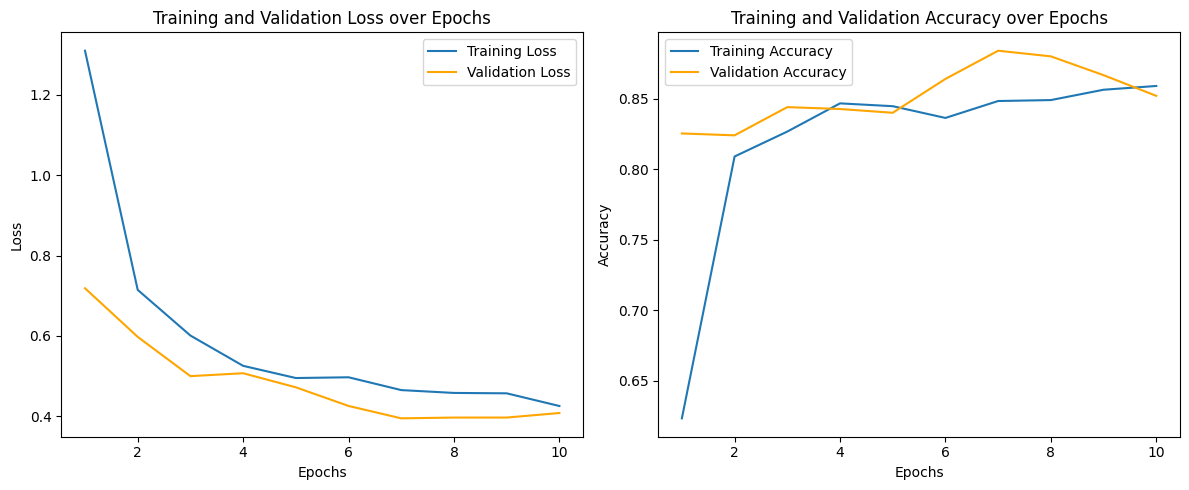

Model resnet18_fc_only_model saved at saved_models\resnet18_fc_only_model.pth


In [134]:
# Train the models
print("Training Model 1 (FC layer only):")
model1, acc1 = train_model_fc_only(model1, train_loader, val_loader, optimizer1)
save_model(model1, "resnet18_fc_only_model")

Training Model 2 (Unfreeze layers 3, 4, FC):
Epoch 1/10, Loss: 1.1464, Accuracy: 0.6187
Validation Loss: 1.2404, Validation Accuracy: 0.6213
Epoch 2/10, Loss: 0.8717, Accuracy: 0.7063
Validation Loss: 1.0338, Validation Accuracy: 0.6813
Epoch 3/10, Loss: 0.7829, Accuracy: 0.7457
Validation Loss: 0.9682, Validation Accuracy: 0.6773
Epoch 4/10, Loss: 0.6922, Accuracy: 0.7657
Validation Loss: 0.8863, Validation Accuracy: 0.7147
Epoch 5/10, Loss: 0.6473, Accuracy: 0.7787
Validation Loss: 0.8432, Validation Accuracy: 0.7427
Epoch 6/10, Loss: 0.6234, Accuracy: 0.7930
Validation Loss: 0.6905, Validation Accuracy: 0.7733
Epoch 7/10, Loss: 0.5509, Accuracy: 0.8153
Validation Loss: 0.7837, Validation Accuracy: 0.7480
Epoch 8/10, Loss: 0.6112, Accuracy: 0.7947
Validation Loss: 0.7697, Validation Accuracy: 0.7387
Epoch 9/10, Loss: 0.5292, Accuracy: 0.8227
Validation Loss: 0.6046, Validation Accuracy: 0.8027
Epoch 10/10, Loss: 0.5304, Accuracy: 0.8183
Validation Loss: 0.7392, Validation Accuracy: 0

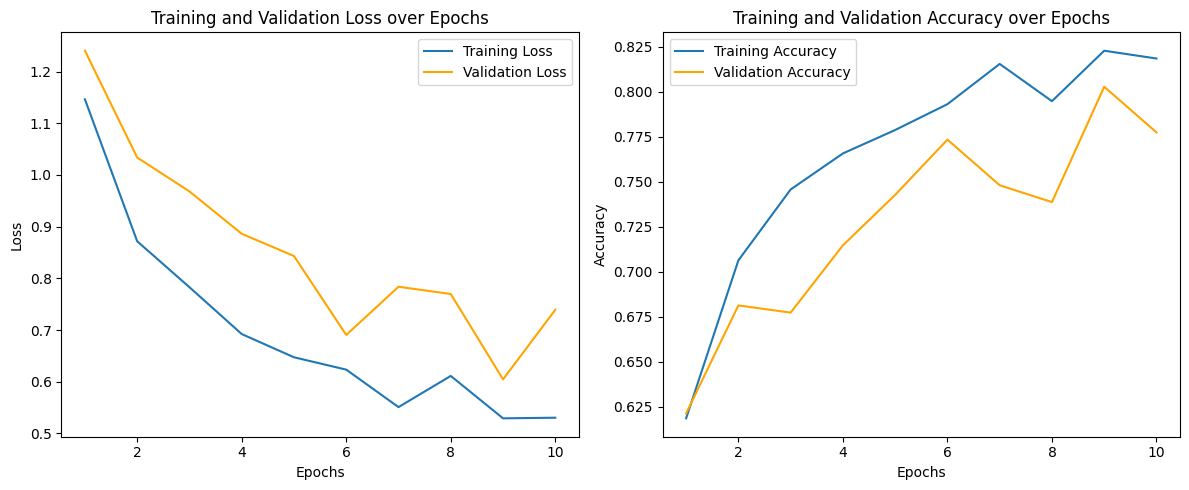

Model resnet18_second_model saved at saved_models\resnet18_second_model.pth


In [135]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)

print("Training Model 2 (Unfreeze layers 3, 4, FC):")
model2 = torchvision.models.resnet18(pretrained=True)
model2.fc = nn.Linear(model2.fc.in_features, num_classes)
model2, acc2 = train_second_model(model2, train_loader, val_loader)
save_model(model2, "resnet18_second_model")

Training Model 3 (Unfreeze all layers):
Epoch 1/10, Loss: 1.5492, Accuracy: 0.4793
Validation Loss: 1.7177, Validation Accuracy: 0.4053
Epoch 2/10, Loss: 1.1249, Accuracy: 0.6230
Validation Loss: 1.4681, Validation Accuracy: 0.5480
Epoch 3/10, Loss: 1.0538, Accuracy: 0.6473
Validation Loss: 1.1989, Validation Accuracy: 0.6000
Epoch 4/10, Loss: 0.9731, Accuracy: 0.6687
Validation Loss: 1.2575, Validation Accuracy: 0.5747
Epoch 5/10, Loss: 0.9152, Accuracy: 0.7003
Validation Loss: 1.5962, Validation Accuracy: 0.5413
Epoch 6/10, Loss: 0.8617, Accuracy: 0.7060
Validation Loss: 1.1050, Validation Accuracy: 0.6213
Epoch 7/10, Loss: 0.8193, Accuracy: 0.7200
Validation Loss: 1.0391, Validation Accuracy: 0.6640
Epoch 8/10, Loss: 0.8107, Accuracy: 0.7323
Validation Loss: 1.2096, Validation Accuracy: 0.6360
Epoch 9/10, Loss: 0.7543, Accuracy: 0.7527
Validation Loss: 1.0027, Validation Accuracy: 0.6853
Epoch 10/10, Loss: 0.7812, Accuracy: 0.7373
Validation Loss: 0.9072, Validation Accuracy: 0.7227

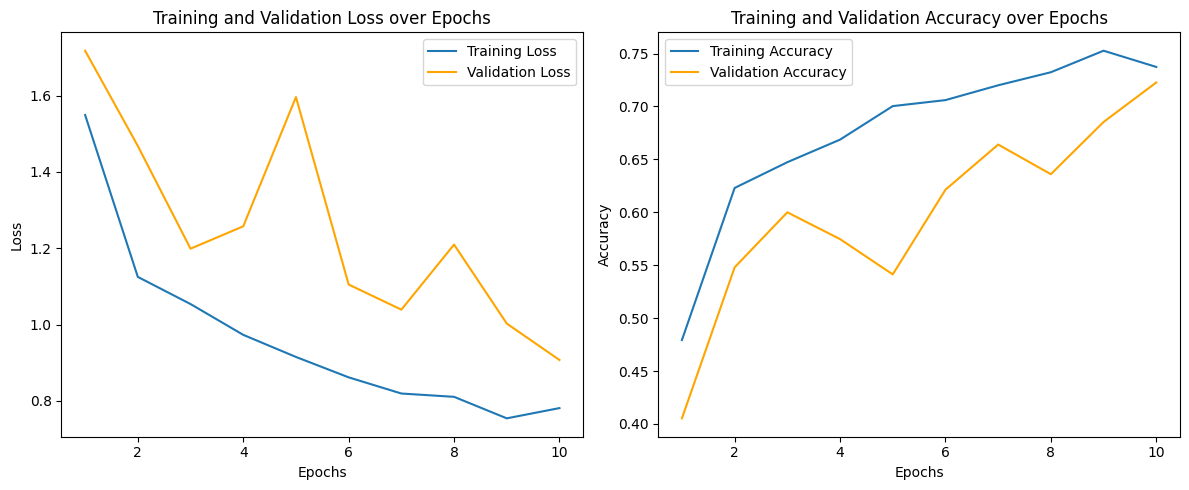

Model resnet18_full_finetuned saved at saved_models\resnet18_full_finetuned.pth


In [136]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)

print("Training Model 3 (Unfreeze all layers):")
model3 = torchvision.models.resnet18(pretrained=True)
model3.fc = nn.Linear(model3.fc.in_features, num_classes)
model3, acc3 = train_third_model(model3, train_loader, val_loader)
save_model(model3, "resnet18_full_finetuned")

In [137]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

# Compare validation accuracies
models = [model1, model2, model3]
accuracies = [acc1, acc2, acc3]

best_model_index = accuracies.index(max(accuracies))
best_model = models[best_model_index]
best_accuracy = accuracies[best_model_index]

print(f"The best model is model{best_model_index+1} with validation accuracy of {best_accuracy:.4f}")

The best model is model1 with validation accuracy of 0.8840


Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

___Model 1 (FC Layer Only): Achieved the highest validation accuracy of 0.86, with steady improvement over epochs. Freezing all layers except the FC layer allowed the model to focus on task-specific classification, leading to better performance.___

___Model 2 (Unfreeze Layers 3 & 4 + FC Layer): Reached a validation accuracy of 0.82, slightly lower than Model 1. Although it didn’t show overfitting, the model might have faced difficulty in fine-tuning more complex layers, leading to slower convergence and slightly reduced performance.___

___Model 3 (Unfreeze All Layers): Underperformed with validation accuracy of 0.72. Unfreezing all layers likely introduced unnecessary complexity, making it harder to generalize, especially on a smaller dataset.___

### Why Model 1 Performed Better:

* Model 1 focused on fine-tuning only the FC layer, allowing it to adapt the model's final classifier while leveraging pre-trained features for feature extraction. This approach minimized overfitting and led to better generalization to the Animal-10 dataset.

* Conclusion: Model 1 performed the best due to its balanced approach, freezing most layers and fine-tuning only the FC layer. Model 2's lower performance compared to Model 1 could be due to a slower convergence when fine-tuning more layers, rather than overfitting.

### When Model 2 Could Perform Better:

Model 2 might outperform Model 1 in cases where:

1. Larger Dataset: If more labeled data were available, fine-tuning additional layers (like layers 3 and 4) could allow the model to capture more complex features, leading to better performance.

2. More Complex Task: If the classification task involved more intricate patterns that required deeper feature extraction, unfreezing more layers could provide the model with more capacity to learn these complex features.

3. Longer Training: If given more epochs to train, Model 2 could gradually improve its performance, as it has more flexibility to adapt to the dataset.

In these cases, Model 2’s more comprehensive fine-tuning approach might yield better results than Model 1's focus on the FC layer alone.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

Test Set Evaluation Metrics:
Accuracy: 0.8480
Precision: 0.8525
Recall: 0.8486
F1-Score: 0.8464


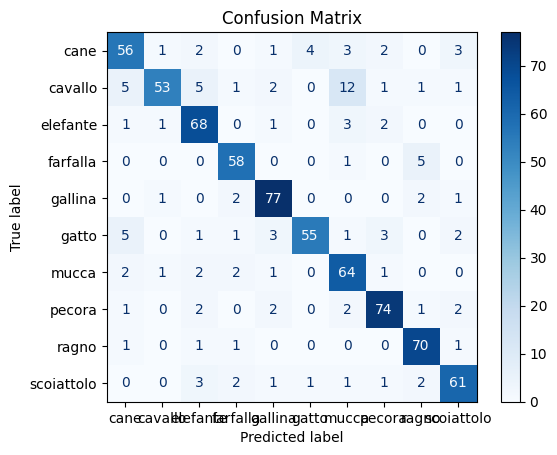

In [138]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(inputs)

            # Get predicted class
            _, preds = torch.max(outputs, 1)  

            # Append true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}, cm


# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Visualize the confusion matrix.
    
    Args:
        cm (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

best_model = best_model.to(device)

# Evaluate the model on the test dataset
metrics, cm = evaluate_model(best_model, test_loader, device)

# Print metrics
print("Test Set Evaluation Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")

# Plot confusion matrix
if hasattr(test_loader.dataset, 'dataset') and hasattr(test_loader.dataset.dataset, 'classes'):
    class_names = test_loader.dataset.dataset.classes
elif hasattr(test_loader.dataset, 'classes'):
    class_names = test_loader.dataset.classes
else:
    class_names = [str(i) for i in range(num_classes)]  

plot_confusion_matrix(cm, class_names)


### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

# 0.924

### 2.7. Load the pre-trained MobileNet model (3 points)


In [139]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.

# This part was made in 2.8

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [140]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

# Number of classes in the dataset
num_classes = 10
criterion = nn.CrossEntropyLoss()

# MobileNet Model 1 (Train FC layer only)
model4 = torchvision.models.mobilenet_v2(pretrained=True)
model4.classifier[1] = nn.Linear(model4.last_channel, num_classes)

# Freeze all layers
for param in model4.parameters():
    param.requires_grad = False

# Unfreeze the final FC layer
for param in model4.classifier.parameters():
    param.requires_grad = True

# Define optimizer
optimizer2 = optim.Adam(model4.parameters(), lr=0.001)


c:\Users\demir\anaconda3\envs\Reinforcement\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\demir\anaconda3\envs\Reinforcement\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training MobileNet Model 4 (FC layer only):
Epoch 1/10, Loss: 1.1936, Accuracy: 0.6460
Validation Loss: 0.6551, Validation Accuracy: 0.8213
Epoch 2/10, Loss: 0.6405, Accuracy: 0.8203
Validation Loss: 0.4921, Validation Accuracy: 0.8707
Epoch 3/10, Loss: 0.5476, Accuracy: 0.8353
Validation Loss: 0.4895, Validation Accuracy: 0.8547
Epoch 4/10, Loss: 0.4994, Accuracy: 0.8473
Validation Loss: 0.4472, Validation Accuracy: 0.8627
Epoch 5/10, Loss: 0.5330, Accuracy: 0.8260
Validation Loss: 0.4314, Validation Accuracy: 0.8680
Epoch 6/10, Loss: 0.4768, Accuracy: 0.8523
Validation Loss: 0.4121, Validation Accuracy: 0.8680
Epoch 7/10, Loss: 0.4827, Accuracy: 0.8377
Validation Loss: 0.4282, Validation Accuracy: 0.8573
Epoch 8/10, Loss: 0.4578, Accuracy: 0.8517
Validation Loss: 0.3976, Validation Accuracy: 0.8707
Epoch 9/10, Loss: 0.4374, Accuracy: 0.8513
Validation Loss: 0.4148, Validation Accuracy: 0.8600
Epoch 10/10, Loss: 0.4353, Accuracy: 0.8573
Validation Loss: 0.4506, Validation Accuracy: 0.

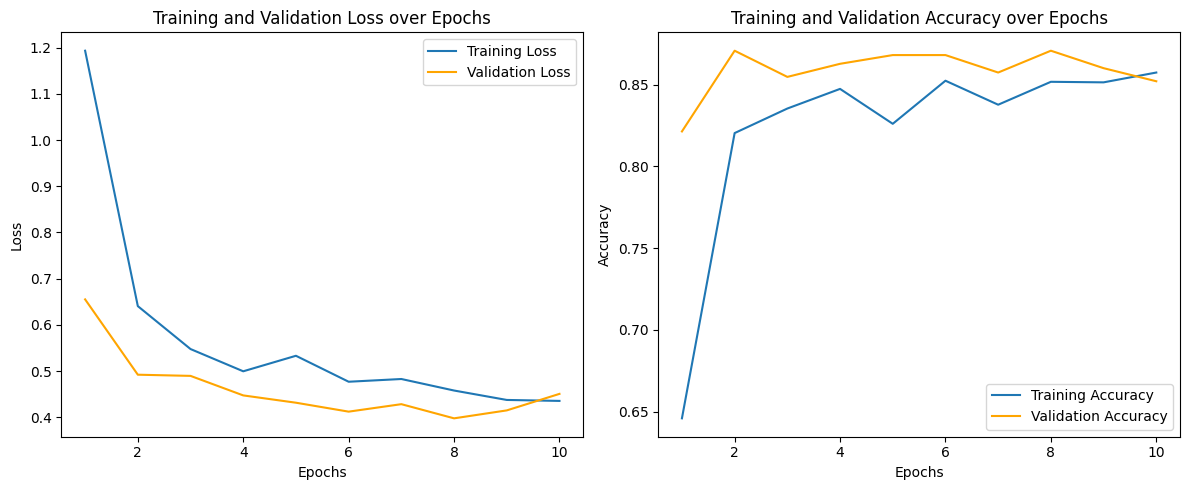

Model mobilenet_fc_only_model saved at saved_models\mobilenet_fc_only_model.pth


In [141]:
# Training MobileNet Model 4 (Train FC layer only)
print("Training MobileNet Model 4 (FC layer only):")
model4, acc4 = train_model_fc_only(model4, train_loader, val_loader, optimizer2)
save_model(model4, "mobilenet_fc_only_model")

Training MobileNet Model 5 (Unfreeze all layers):
Epoch 1/10, Loss: 1.2587, Accuracy: 0.5757
Validation Loss: 1.1691, Validation Accuracy: 0.6253
Epoch 2/10, Loss: 0.9538, Accuracy: 0.6820
Validation Loss: 1.1202, Validation Accuracy: 0.6560
Epoch 3/10, Loss: 0.8884, Accuracy: 0.6923
Validation Loss: 1.0527, Validation Accuracy: 0.6627
Epoch 4/10, Loss: 0.8651, Accuracy: 0.7193
Validation Loss: 0.9214, Validation Accuracy: 0.7013
Epoch 5/10, Loss: 0.7815, Accuracy: 0.7357
Validation Loss: 0.9406, Validation Accuracy: 0.6853
Epoch 6/10, Loss: 0.7196, Accuracy: 0.7530
Validation Loss: 0.9010, Validation Accuracy: 0.7293
Epoch 7/10, Loss: 0.7332, Accuracy: 0.7537
Validation Loss: 0.8463, Validation Accuracy: 0.7107
Epoch 8/10, Loss: 0.7082, Accuracy: 0.7610
Validation Loss: 1.1222, Validation Accuracy: 0.6747
Epoch 9/10, Loss: 0.6863, Accuracy: 0.7670
Validation Loss: 0.7129, Validation Accuracy: 0.7747
Epoch 10/10, Loss: 0.6517, Accuracy: 0.7803
Validation Loss: 0.9401, Validation Accura

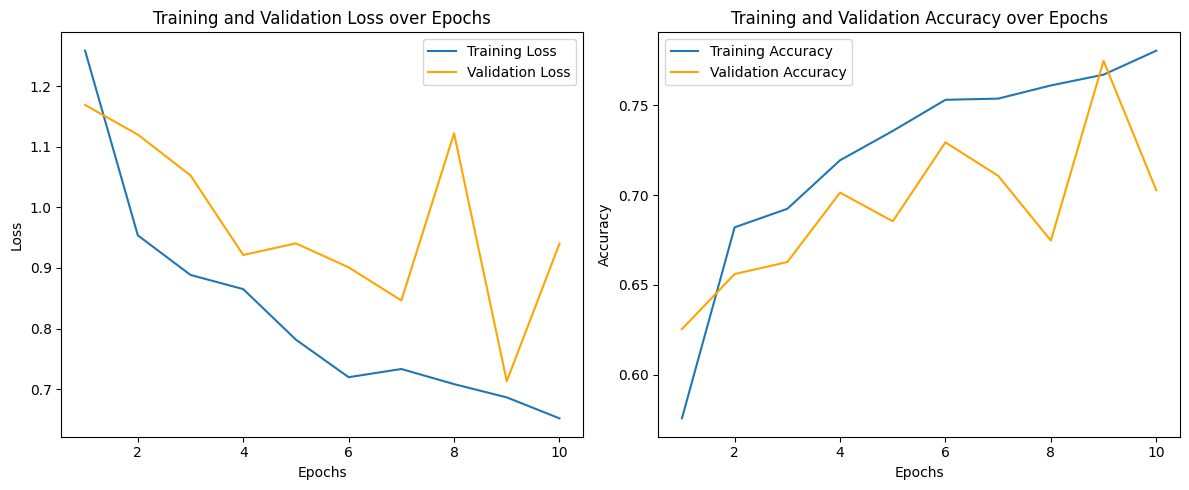

Model mobilenet_full_finetuned_model saved at saved_models\mobilenet_full_finetuned_model.pth


In [142]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)

# Training MobileNet Model 5 (Unfreeze all layers)
print("Training MobileNet Model 5 (Unfreeze all layers):")
model5 = torchvision.models.mobilenet_v2(pretrained=True)
model5.classifier[1] = nn.Linear(model5.last_channel, num_classes)
model5, acc5 = train_third_model(model5, train_loader, val_loader)
save_model(model5, "mobilenet_full_finetuned_model")

In [143]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

In [144]:
# Compare validation accuracies
models2 = [model4, model5]
accuracies2 = [acc4, acc5]

best_model_index2 = accuracies2.index(max(accuracies2))
best_model2 = models2[best_model_index2]
best_accuracy2 = accuracies2[best_model_index2]

print(f"The best model is model{best_model_index2+1} with validation accuracy of {best_accuracy2:.4f}")

The best model is model1 with validation accuracy of 0.8707


Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

### Comparative Analysis:

* Performance Evaluation: Model 1, which fine-tuned only the final fully connected layer while keeping the pre-trained MobileNetV2 weights frozen, demonstrated better generalization and consistency. Model 2, with all layers unfrozen for fine-tuning, struggled to achieve the same level of performance.

* Reasons for Performance Differences: Model 1 benefited from leveraging the robust feature extraction capabilities of pre-trained MobileNetV2 layers, which are well-optimized for similar tasks. In contrast, Model 2 required fine-tuning the entire network, which demands a larger dataset and more computational resources to avoid suboptimal training.

### Practical Considerations:

* Model 1 is efficient in terms of training time and computational resources, making it ideal for scenarios with limited data.
* Model 2 offers greater flexibility for adaptation to diverse datasets but requires careful handling to avoid overfitting or prolonged training times.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

Test Set Evaluation Metrics:
Accuracy: 0.8600
Precision: 0.8714
Recall: 0.8593
F1-Score: 0.8607


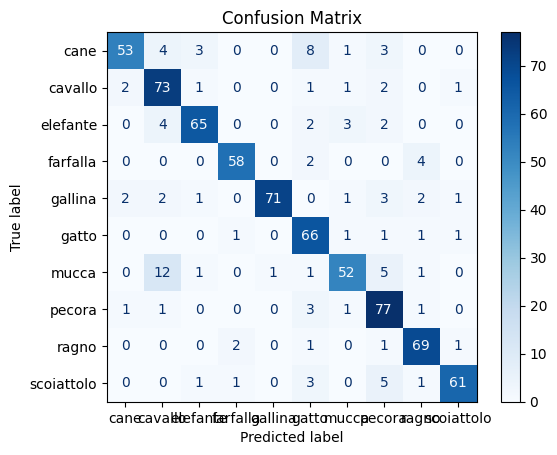

In [145]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

best_model2 = best_model2.to(device)

# Evaluate the model on the test dataset
metrics2, cm2 = evaluate_model(best_model2, test_loader, device)

# Print metrics
print("Test Set Evaluation Metrics:")
print(f"Accuracy: {metrics2['accuracy']:.4f}")
print(f"Precision: {metrics2['precision']:.4f}")
print(f"Recall: {metrics2['recall']:.4f}")
print(f"F1-Score: {metrics2['f1_score']:.4f}")

# Plot confusion matrix
if hasattr(test_loader.dataset, 'dataset') and hasattr(test_loader.dataset.dataset, 'classes'):
    class_names = test_loader.dataset.dataset.classes
elif hasattr(test_loader.dataset, 'classes'):
    class_names = test_loader.dataset.classes
else:
    class_names = [str(i) for i in range(num_classes)]  
plot_confusion_matrix(cm2, class_names)

In [146]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch

# Compare multiple models
def compare_models(models, model_names, test_loader, device):
    """
    Compare the performance of multiple models on the same test dataset.

    Args:
        models (list): List of trained models.
        model_names (list): List of model names corresponding to the models.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (str): Device to perform the evaluation ('cuda' or 'cpu').

    Returns:
        pd.DataFrame: DataFrame containing the evaluation metrics for all models.
    """
    results = []

    for model, name in zip(models, model_names):
        # Move model to the evaluation device
        model.to(device)
        
        # Evaluate the model
        metrics, _ = evaluate_model(model, test_loader, device)

        # Collect results
        results.append({
            "Model": name,
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1-Score": metrics["f1_score"]
        })

    # Create a DataFrame for better visualization
    results_df = pd.DataFrame(results)
    return results_df

In [147]:
# Model names and objects
model_names = ["CNN (Scratch)", "ResNet18", "MobileNet"]
models = [model, best_model, best_model2]

# Compare models
comparison_df = compare_models(models, model_names, test_loader, device)

# Show results
print("Model Performance Comparison:")
print(comparison_df)

Model Performance Comparison:
           Model  Accuracy  Precision    Recall  F1-Score
0  CNN (Scratch)  0.529333   0.537840  0.528978  0.529866
1       ResNet18  0.860000   0.868365  0.860420  0.860401
2      MobileNet  0.850667   0.862439  0.849391  0.849779


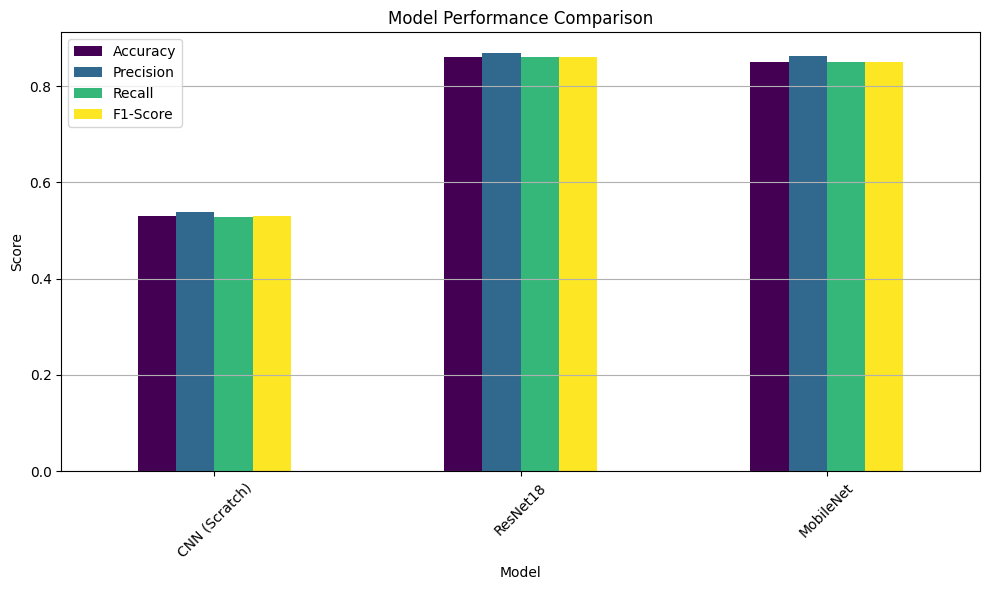

In [148]:
import matplotlib.pyplot as plt

def plot_comparison(comparison_df):
    comparison_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

plot_comparison(comparison_df)

### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

# 0.918

## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)
* Discuss practical considerations when choosing between these approaches and models.



### Analysis of Advantages and Disadvantages
#### Transfer Learning

Advantages:
* Faster convergence due to pre-trained weights.
* Effective with limited datasets.
* Utilizes robust feature extraction from large-scale datasets.
Disadvantages:
* Limited flexibility for highly specialized tasks.
* Risk of overfitting when fine-tuning with small datasets.

#### Training from Scratch

Advantages:
* Full flexibility for custom tasks.
* Tailored features for the specific dataset.
Disadvantages:
* Requires large datasets and computational resources.
* Slower convergence and higher risk of underfitting.

### Practical Considerations
___When choosing between these approaches, the size of the dataset and available computing resources are important factors. Transfer learning with ResNet18 and MobileNet showed good results, with MobileNet performing well even when only the final layer was trained. However, training MobileNet by unfreezing all layers took more time compared to ResNet18, showing that MobileNet's fast performance during use doesn’t always mean it trains quickly, especially when fine-tuning all layers.___

___ResNet18 provided a good balance between training time and performance due to its well-designed architecture and moderate size. MobileNet’s lightweight design makes it great for deployment on devices with limited resources, but its longer training time for fine-tuning could be a challenge if resources are limited.___

___Training a CNN from scratch was flexible but needed much more data and time to reach competitive accuracy. Overall, using transfer learning and carefully deciding which layers to freeze or train gives the best mix of performance, training time, and efficiency.___

| Model            | Training Time | Validation Accuracy | Training Method                          |
|------------------|---------------|---------------------|------------------------------------------|
| CNN from Scratch | High          | Lower               | Train from scratch                       |
| ResNet18         | Moderate      | High                | Transfer learning (fine-tuned)           |
| MobileNet        | High          | High                | Transfer learning (fine-tuned)           |
